In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# 변경하고자 하는 새로운 디렉토리 경로
new_directory = '/content/drive/MyDrive'

# 디렉토리 위치 변경
os.chdir(new_directory)

# 변경된 디렉토리 경로 출력
print("Current directory:", os.getcwd())


Current directory: /content/drive/MyDrive


# 텐서

In [5]:
import pandas as pd
import numpy as np
from dezero.core_simple import Variable
from dezero.core_simple import Function

## Dezero 용 reshape 함수 구현
- Reshape 클래스를 초기화할 때 변형 목표가 되는 형상을 shape 인수로 받음

- 순전파시에 넘파이의 reshape 함수를 사용하여 형상을 변환

In [6]:
class Reshape(Function):
  def __init__(self, shape):
    self.shape = shape

  def forward(self,x):
    self.x_shape = x.shape
    y = x.reshape(self.shape)
    return y

  def backward(self, gy):
    return reshape(gy, self.x_shape)


def reshape(x, shape):
  if x.shape == shape:
    return as_variable(x)
  return Reshape(shape)(x)


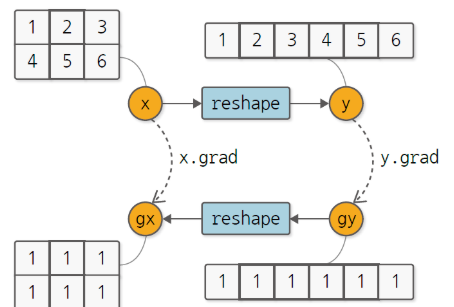

reshape 함술르 사용하여 형상을 변환

역전파를 수행하여 x의 기울기를 구함

이과정에서 y의 기울기도 자동으로 채워짐

원소는 모두 1로 이루어진 텐서

DeZero의 reshape 함수를 넘파이의 reshape와 비슷하게 만들기

- Variable 클래스에 가변 인수를 받는 reshape 메서드 추가

In [7]:
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        def reshape(self, *shape):
          if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
            shape = shape[0]
          return dezero.functions.reshape(self, shape)


## 형렬의 전치

- 넘파이의 transpose 함수

- 텐서의 원소 자체는 그대로이고 형상만 바뀜

- 역전파에서는 출력 쪽에서 전해지는 기울기의 형상만 변경함

- 순전파 때와 정확히 반대 형태

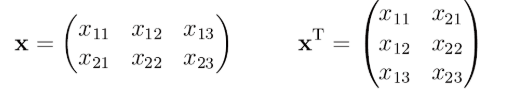


In [8]:
# Dezero의 transpose 구현
class Transpose(Function):
  def forward(self, x):
    y = np.transpose(x)
    return y

  def backward(self, gy):
    gx = transpose(gy)
    return gx

def transpose(x):
  return Transpose()(x)


- Variable 클래스에 transpose 함수 추가

In [9]:
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        def transpose(self):
          return dezero.functions.transpose(self)

        @property
        def T(self):
          return dezero.functions.transpose(self)



형상이 (A,B,C,D)인 데이터의 축을 np.transpose 함수를 사용하여 변환함

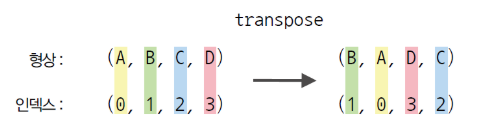

- 축의 순서를 지정하면 그에 맞게 데이터의 축이 달라짐
- 인수를 None으로 주면 축이 역순으로 정렬됨
- x가 행렬일 때 x.transpose()를 실행하면 행렬이 전치됨

(0번째와 1번째 축의 데이터가 1번째와 0번째 순서로 바뀜

## DeZero에 합계를 구하는 Sum 함수 추가
- 덧셈의 미분

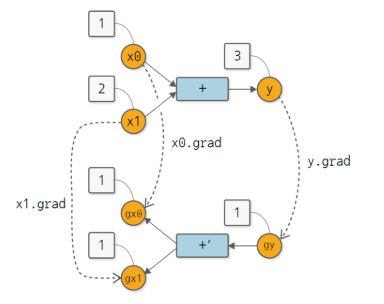

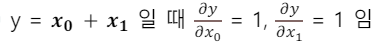
- 역전파는 출력 쪽에서 전해지는 기울기를 그대로 입력 쪽으로 흘려보냄
- 덧셈을 수행한 후 변수 y로 부터 역전파함
- x0와 x1에는 출력 쪽에서 전해준 1이라는 기울기를 두 개로 복사하여 전달


<원소가 2개로 구성된 벡터 합의 역전파>
- 벡터에 sum 함수를 적용하면 스칼라를 출력
- 역전파는 출력 쪽에서 전해준 값인 1을 [1,1]이라는 벡터로 확장

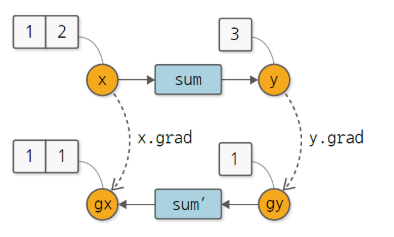

<원소가 2개이상인 벡터의 합의 역전파>
- 기울기 벡터의 원소 수만큼 복사
- 기울기를 입력 변수의 형상과 같아지도록 복사
- 입력 변수가 2차원 이상의 배열일 때도 동일하게 적용

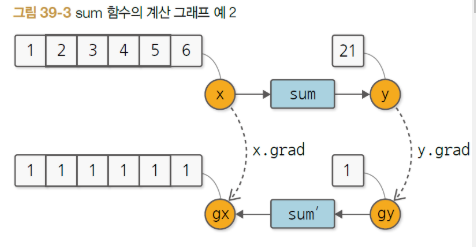

In [10]:
# 구현
class Sum(Function):
  def forward(self,x):
    self.x_shape = x.shape
    y = x.sum()
    return y

# broadcast_to 함수 사용
# Variable 인스턴스인 x의 원소를 복사하여 shape인수로 지정한
# 형상이 되도록 만들어주는 함수
  def backward(self, gy):
    gx = broadcast_to(gy, self.x_shape)
    return gx

def sum(x):
  return Sum()(x)



## axis와 keepdims
<axis(축) 지정 인수>
= 합계를 구할 때 축을 지정할 수 있음

<keepdims 인수>
- keepdims 는 입력과 출력의 차원 수(축 수)를 똑같게 유지할지 정하는 플래그
- True면 축의 수 유지
- False 면 y의 형상은 스칼라

In [11]:
# Sum 함수에 적용
class Sum(Function):
  def __init__(self, axis, keepdims):
    self.axis = axis
    self.keepdims = keepdims

  def forward(self,x):
    self.x_shape = x.shape
    y = x.sum(axis = self.axis, keepdims = self.keepdims)
    return y

  def backward(self, gy):
    gy = utils.reshape_sum_backward(gy, self.x_shape, self.axis, self.keepdims)
    gx = broadcast_to(gy, self.x_shape)
    return gx

def sum(x, axis = None, keepdims = False):
  return Sum(axis, keepdims)(x)

## 넘파이 브로드캐스트
- 서로 다른 형상을 가진 배열들간에 산술 연산을 수행하기 위해 배열의 형상을 조정
- 브로드 캐스트를 사용하여 작은 배열을 큰 배열에 맞추어 연산 수행 가능

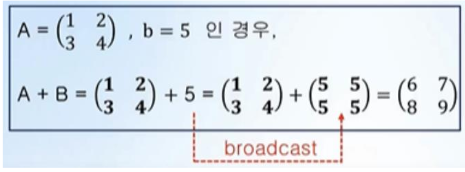

broadcast_to 함수 sum_to 함수 구현

In [14]:
from dezero.utils import sum_to

class BroadcastTo(Function):
  def __init__(self, shape):
    self.shape = shape

  def forward(self, x):
    self.x_shape = x.shape
    xp = dezero.cuda.get_array_module(x)
    y = xp.broadcast_to(x, self.shape)
    return y

  def backward(self, gy):
    gx = sum_to(gy, self.x_shape)
    return gx

def broadcast_to(x, shape):
  if x.shape == shape:
    return as_variable(x)
  return BroadcastTo(shape)(x)

class SumTo(Function):
  def __init__(self, shape):
    self.shape = shape

  def forward(self, x):
    self.x_shape = x.shape
    y = utils.sum_to(x, self.shape)
    return y

  def backward(self, gy):
    gx = broadcast_to(gy, self)
    return gx

def sum_to(x, shape):
  if x.shape == shape:
    return as_variable(x)
  return SumTo(shape)(x)


<브로드캐스트>
- 형상이 다른 다차원 배열끼리의 연산을 가능하게 하는 넘파이 가능
- sum_to 함수를 구현한 이유는 넘파이 브로드캐스트에 대응하기 위함
- x0와 x1은 형상이 다르지만, 계산 과정에서 x1의 원소가 x0형상에 맞춰 복제됨
- 브로드캐스트는 순전파에서만 일어남. 역전파는 일어나지 않음


<브로드캐스트 역전파>
- DeZero의 Add 클래스 수정

In [15]:
class Add(Function):
  def forward(self, x0,x1):
    self.x0_shape, self.x1_shape = x0.shape, x1.shape
    y = x0 + x1
    return y

  def backward(self, gy):
    gx0, gx1 = gy, gy
    if self.x0_shape != self.x1_shape:
      gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
      gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
    return gx0, gx1

## 행렬의 형상 체크
- 형상에 주의해야함
- 행렬 a와 b의 대응하는 차원의 원소 수가 일치해야함
- 결과로 만들어진 행렬 c의 형상은 행렬 a와 같은 수의 행을, 행렬 b와 같은 수의 열을 가짐

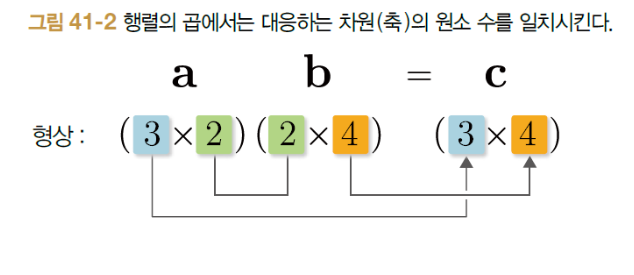

<행렬 곱의 역전파>
- 최종적으로 스칼라를 출력하는 계산을 다룸

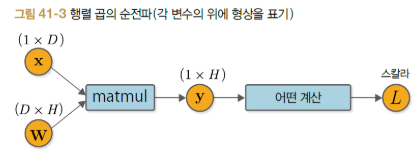

In [16]:
class MatMul(Function):
  def forward(self, x, W):
    y = x.dot(W)
    return y

  def backward(self, gy):
    x, W = self.inputs
    gx = matmul(gy, W.T)
    gW = matmul(x.T, gy)
    return gx, gW

def matmul(x, W):
  return MatMul()(x,W)